#Liam McKenzie
##HW Wk8/9: kNN vs. MLP Model Comparison
###Data set used:  
https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/robustbase/CrohnD.csv  
*Note: Both Google Gemini 2.5 Flash and Claude Sonnet 4.5 were used at various points in this notebook.  
All instances of LLM use have been noted for respected cells.*

In [ ]:
#utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold,train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from scipy import stats

# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# model evaluation routines
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#Helper Functions

I used Google Gemini Flash 2.5 to help build this helper function which allows for replicable mean accuracy with set confidence interval of 95%

In [ ]:

def cv_mean_with_ci(scores, confidence_level=0.95):
    scores = np.array(scores)
    mean = np.mean(scores)
    sem = stats.sem(scores)
    df = len(scores) - 1
    ci = stats.t.interval(confidence_level, df, loc=mean, scale=sem)
    return mean, ci[0], ci[1]

Using the classification_confint as defined in Prof. Mandal's Jupyter Notebook "Multi_Layered_Perceptron" : https://github.com/IndraniMandal/New-Revisions/blob/main/Multi_Layered_Perceptron.ipynb

In [ ]:
def classification_confint(acc, n):
    '''
    Compute the 95% confidence interval for a classification problem.
      acc -- classification accuracy
      n   -- number of observations used to compute the accuracy
    Returns a tuple (lb,ub)
    '''
    import math
    interval = 1.96*math.sqrt(acc*(1-acc)/n)
    lb = max(0, acc - interval)
    ub = min(1.0, acc + interval)
    return (lb,ub)

#Import and View Data, pre-process as necessary

In [ ]:
url = "https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/robustbase/CrohnD.csv"
crohnDF = pd.read_csv(url)
crohnDF.head()

,rownames,ID,nrAdvE,BMI,height,country,sex,age,weight,treat
0,1,19908,4,25.22,163,c1,F,47,67,placebo
1,2,19909,4,23.80,164,c1,F,53,64,d1
2,3,19910,1,23.05,164,c1,F,68,62,placebo
3,4,20908,1,25.71,165,c1,F,48,70,d2
4,5,20909,2,25.95,170,c1,F,67,75,placebo


In [ ]:
crohnDF.drop(columns=["rownames"], inplace=True)
crohnDF.drop(columns=["country"], inplace=True)
crohnDF.head()

,ID,nrAdvE,BMI,height,sex,age,weight,treat
0,19908,4,25.22,163,F,47,67,placebo
1,19909,4,23.80,164,F,53,64,d1
2,19910,1,23.05,164,F,68,62,placebo
3,20908,1,25.71,165,F,48,70,d2
4,20909,2,25.95,170,F,67,75,placebo


While preparing the data for model training, I created a new column to track whether patient had an adverse event, which is based on 'nrAdvE'. I use this new column as my target and drop 'nrAdvE' from the table when defining features. The 'has_adverse_event' is a 0/1 boolean set to if 'nrAdvE' is > 0. In testing, this provided significantly better accuracy results than raw 'nrAdvE'.

In [ ]:
#create binary target: 1 if patient had any adverse events, 0 otherwise
crohnDF['has_adverse_event'] = (crohnDF['nrAdvE'] > 0).astype(int)

In [ ]:
#check class balance
print("Class distribution:")
print(crohnDF['has_adverse_event'].value_counts())
print("\nPercentages:")
print(crohnDF['has_adverse_event'].value_counts(normalize=True))

Class distribution:
has_adverse_event
1    67
0    50
Name: count, dtype: int64

Percentages:
has_adverse_event
1    0.57265
0    0.42735
Name: proportion, dtype: float64


In [ ]:
target = crohnDF['has_adverse_event']
features = crohnDF.drop(columns=['has_adverse_event', 'nrAdvE'])

Validate data integrity

In [ ]:
crohnDF.isnull().sum()

,0
ID,0
nrAdvE,0
BMI,0
height,0
sex,0
age,0
weight,0
treat,0
has_adverse_event,0


In [ ]:
#data types
crohnDF.dtypes

,0
ID,int64
nrAdvE,int64
BMI,float64
height,int64
sex,object
age,int64
weight,int64
treat,object
has_adverse_event,int64


#Set up Model Features

In [ ]:
#determine target and features of the dataset
target = crohnDF['has_adverse_event']
features = crohnDF.drop(columns=['has_adverse_event', 'nrAdvE'])
le = LabelEncoder()
features['sex'] = le.fit_transform(features['sex'])
features['treat'] = le.fit_transform(features['treat'])

# Encode the 'sex' column
features['sex'] = le.fit_transform(features['sex'])

# Encode any other non-float columns in features
for col in features.columns:
    if features[col].dtype == 'object': # Assuming non-float columns are of type object
        features[col] = le.fit_transform(features[col])

#binary target: 1 if patient had any adverse events, 0 otherwise
crohnDF['has_adverse_event'] = (crohnDF['nrAdvE'] > 0).astype(int)
print("\nFeatures used for prediction:")
print(features.columns.tolist())



Features used for prediction:
['ID', 'BMI', 'height', 'sex', 'age', 'weight', 'treat']


#kNN Model

In [ ]:
# do train and test
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.8, test_size=0.2, random_state=42)
# set up a base model for grid search
base_model = KNeighborsClassifier()


In [ ]:
#train the model
cv = KFold(n_splits=5, shuffle=True, random_state=42)
paramGrid = {'n_neighbors': list(range(1,26))}
knnGrid = GridSearchCV(base_model, paramGrid, cv=cv, scoring='accuracy')
knnGrid.fit(X_train, y_train)
print("Grid Search: best parameters: {}".format(knnGrid.best_params_))

Grid Search: best parameters: {'n_neighbors': 5}


In [ ]:
#get best model from gridsearch
bestKnnModel = knnGrid.best_estimator_

#evaluate the best model using cross-validation on the training data
knnCvScores = cross_val_score(bestKnnModel, X_train, y_train, cv=cv)

#accuracy of best model with confidence interval using the user's function
knnMeanAcc, knnLowerBound, knnUpperBound = cv_mean_with_ci(knnCvScores)
print("kNN Cross-validated Accuracy: {:3.2f} ({:3.2f}, {:3.2f})".format(
    knnMeanAcc, knnLowerBound, knnUpperBound))

kNN Cross-validated Accuracy: 0.68 (0.54, 0.82)


In [ ]:
#test the best kNN model on test set
knnPredictY = bestKnnModel.predict(X_test)
knnTestAcc = accuracy_score(y_test, knnPredictY)
knnTestLb, knnTestUb = classification_confint(knnTestAcc, X_test.shape[0])
print("kNN Test Accuracy: {:3.2f} ({:3.2f}, {:3.2f})".format(
    knnTestAcc, knnTestLb, knnTestUb))

kNN Test Accuracy: 0.67 (0.48, 0.86)


##kNN Summary:
*Note: Claude Sonnet 4.5 assisted in graphics generation*



In [ ]:
print("Grid Search: best parameters: {}".format(knnGrid.best_params_))
print("kNN Cross-validated Accuracy: {:3.2f} ({:3.2f}, {:3.2f})".format(
    knnMeanAcc, knnLowerBound, knnUpperBound))
print("kNN Test Accuracy: {:3.2f} ({:3.2f}, {:3.2f})".format(
    knnTestAcc, knnTestLb, knnTestUb))

Grid Search: best parameters: {'n_neighbors': 5}
kNN Cross-validated Accuracy: 0.68 (0.54, 0.82)
kNN Test Accuracy: 0.67 (0.48, 0.86)


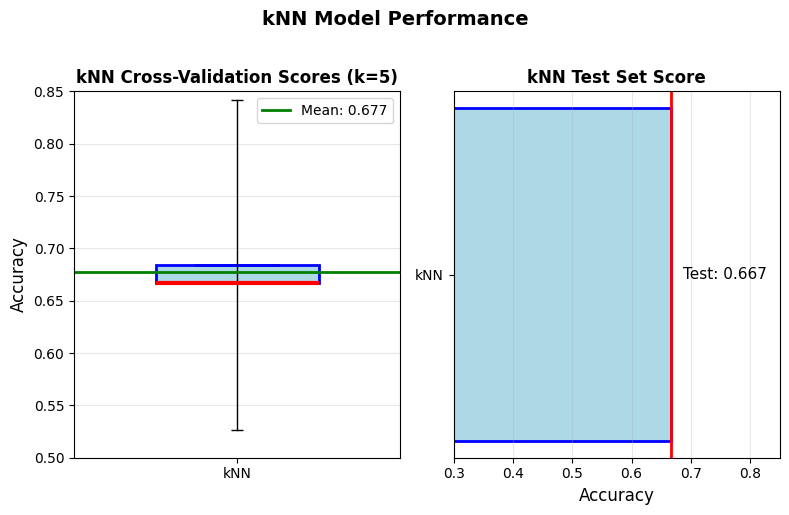

In [ ]:
"""#kNN Performance Visualization"""
fig, axes = plt.subplots(1, 2, figsize=(8, 5))

# kNN Cross-Validation Scores
bp1 = axes[0].boxplot(knnCvScores, vert=True, patch_artist=True, widths=0.5,
                boxprops=dict(facecolor='lightblue', color='blue', linewidth=2),
                medianprops=dict(color='red', linewidth=3,),
                whiskerprops=dict(color='blue', linewidth=2),
                capprops=dict(color='blue', linewidth=2),
                flierprops=dict(marker='_', markerfacecolor='red', markersize=8, linestyle='solid'))
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('kNN Cross-Validation Scores (k={})'.format(knnGrid.best_params_['n_neighbors']),
                  fontsize=12, fontweight='bold')
axes[0].set_xticklabels(['kNN'])
axes[0].set_ylim([0.5, 0.85])
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].axhline(y=knnMeanAcc, color='green', linestyle='solid', linewidth=2, label='Mean: {:.3f}'.format(knnMeanAcc))
axes[0].legend()

# kNN Test Score - show as a horizontal bar instead
axes[1].barh(['kNN'], [knnTestAcc], color='lightblue', edgecolor='blue', linewidth=2, height=0.4)
axes[1].set_xlabel('Accuracy', fontsize=12)
axes[1].set_title('kNN Test Set Score', fontsize=12, fontweight='bold')
axes[1].set_xlim([0.3, 0.85])
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].axvline(x=knnTestAcc, color='red', linestyle='solid', linewidth=2)
axes[1].text(knnTestAcc + 0.02, 0, 'Test: {:.3f}'.format(knnTestAcc), fontsize=11, va='center')

fig.suptitle('kNN Model Performance', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

#MLP Model

In [ ]:
#set up neural network
model = MLPClassifier(max_iter=10000, random_state=42)

#define the parameter grid for grid search
param_grid = {
    'hidden_layer_sizes':
    [
      (10,), (20,),
      (10, 10), (20, 10)
    ],
    'activation': ['relu', 'logistic'],
}

In [ ]:
#perform grid search with 5-fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
mlpGrid = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy')

#fit the grid search on training data
mlpGrid.fit(X_train, y_train)
print("Grid Search: best parameters: {}".format(mlpGrid.best_params_))

Grid Search: best parameters: {'activation': 'relu', 'hidden_layer_sizes': (10,)}


In [ ]:
#get the best model
best_mlp_model = mlpGrid.best_estimator_

#evaluate the best MLP model using cross-validation on training data
mlp_cv_scores = cross_val_score(best_mlp_model, X_train, y_train, cv=cv)

# Calculate mean accuracy with confidence interval
mlp_mean_acc, mlp_lower_bound, mlp_upper_bound = cv_mean_with_ci(mlp_cv_scores)
print("MLP Cross-validated Accuracy: {:3.2f} ({:3.2f}, {:3.2f})".format(
    mlp_mean_acc, mlp_lower_bound, mlp_upper_bound))

MLP Cross-validated Accuracy: 0.54 (0.40, 0.68)


In [ ]:
#test the best MLP model on test set
mlp_predict_y = best_mlp_model.predict(X_test)
mlp_test_acc = accuracy_score(y_test, mlp_predict_y)
mlp_test_lb, mlp_test_ub = classification_confint(mlp_test_acc, X_test.shape[0])
print("MLP Test Accuracy: {:3.2f} ({:3.2f}, {:3.2f})".format(
    mlp_test_acc, mlp_test_lb, mlp_test_ub))

MLP Test Accuracy: 0.71 (0.53, 0.89)


##MLP Summary:
*Note: Claude Sonnet 4.5 assisted in graphics generation*



In [ ]:
print("Grid Search: best parameters: {}".format(mlpGrid.best_params_))
print("MLP Cross-validated Accuracy: {:3.2f} ({:3.2f}, {:3.2f})".format(
    mlp_mean_acc, mlp_lower_bound, mlp_upper_bound))
print("MLP Test Accuracy: {:3.2f} ({:3.2f}, {:3.2f})".format(
    mlp_test_acc, mlp_test_lb, mlp_test_ub))

Grid Search: best parameters: {'activation': 'relu', 'hidden_layer_sizes': (10,)}
MLP Cross-validated Accuracy: 0.54 (0.40, 0.68)
MLP Test Accuracy: 0.71 (0.53, 0.89)


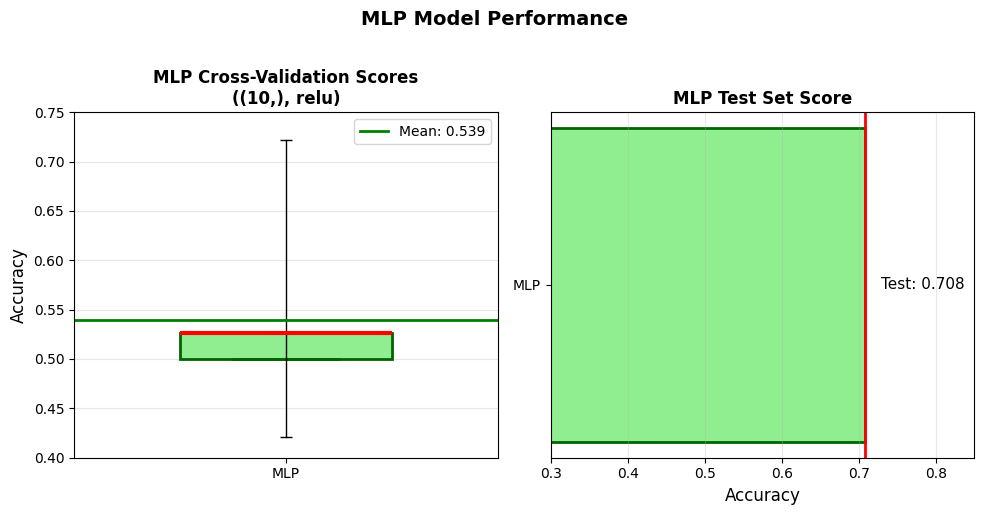

In [ ]:
"""#MLP Performance Visualization"""
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# MLP Cross-Validation Scores
bp1 = axes[0].boxplot(mlp_cv_scores, vert=True, patch_artist=True, widths=0.5,
                boxprops=dict(facecolor='lightgreen', color='darkgreen', linewidth=2),
                medianprops=dict(color='red', linewidth=3),
                whiskerprops=dict(color='darkgreen', linewidth=2),
                capprops=dict(color='darkgreen', linewidth=2),
                flierprops=dict(marker='_', markerfacecolor='red', markersize=8, linestyle='solid'))
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('MLP Cross-Validation Scores\n({}, {})'.format(
    mlpGrid.best_params_['hidden_layer_sizes'],
    mlpGrid.best_params_['activation']),
    fontsize=12, fontweight='bold')
axes[0].set_xticklabels(['MLP'])
axes[0].set_ylim([0.4, 0.75])
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].axhline(y=mlp_mean_acc, color='green', linestyle='solid', linewidth=2, label='Mean: {:.3f}'.format(mlp_mean_acc))
axes[0].legend()

# MLP Test Score - show as a horizontal bar instead
axes[1].barh(['MLP'], [mlp_test_acc], color='lightgreen', edgecolor='darkgreen', linewidth=2, height=0.4)
axes[1].set_xlabel('Accuracy', fontsize=12)
axes[1].set_title('MLP Test Set Score', fontsize=12, fontweight='bold')
axes[1].set_xlim([0.3, 0.85])
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].axvline(x=mlp_test_acc, color='red', linestyle='solid', linewidth=2)
axes[1].text(mlp_test_acc + 0.02, 0, 'Test: {:.3f}'.format(mlp_test_acc), fontsize=11, va='center')

fig.suptitle('MLP Model Performance', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

#Model Comparison

##kNN Results

In [ ]:
print("kNN Model:")
print("  Best k: {}".format(knnGrid.best_params_['n_neighbors']))
print("  Cross-validated Accuracy: {:3.2f} ({:3.2f}, {:3.2f})".format(
    knnMeanAcc, knnLowerBound, knnUpperBound))
print("  Test Accuracy: {:3.2f} ({:3.2f}, {:3.2f})".format(
    knnTestAcc, knnTestLb, knnTestUb))

kNN Model:
  Best k: 5
  Cross-validated Accuracy: 0.68 (0.54, 0.82)
  Test Accuracy: 0.67 (0.48, 0.86)


##MLP Results

In [ ]:
print("MLP Model:")
print("  Best hidden layers: {}".format(mlpGrid.best_params_['hidden_layer_sizes']))
print("  Best activation: {}".format(mlpGrid.best_params_['activation']))
print("  Cross-validated Accuracy: {:3.2f} ({:3.2f}, {:3.2f})".format(
    mlp_mean_acc, mlp_lower_bound, mlp_upper_bound))
print("  Test Accuracy: {:3.2f} ({:3.2f}, {:3.2f})".format(
    mlp_test_acc, mlp_test_lb, mlp_test_ub))

MLP Model:
  Best hidden layers: (10,)
  Best activation: relu
  Cross-validated Accuracy: 0.54 (0.40, 0.68)
  Test Accuracy: 0.71 (0.53, 0.89)


##Statistical Significance Analysis

In [ ]:
#check if confidence intervals overlap for cross-validation
knnCiOverlapsMlp = not (knnLowerBound > mlp_upper_bound or knnUpperBound < mlp_lower_bound)

print("Cross-validation comparison:")
print("  kNN CI: ({:3.2f}, {:3.2f})".format(knnLowerBound, knnUpperBound))
print("  MLP CI: ({:3.2f}, {:3.2f})".format(mlp_lower_bound, mlp_upper_bound))
print("  Confidence intervals overlap: {}".format(knnCiOverlapsMlp))

if knnCiOverlapsMlp:
    print("The difference is NOT statistically significant at the 95% level")
else:
    if knnMeanAcc > mlp_mean_acc:
        print("kNN is statistically significantly better than MLP")
    else:
        print("MLP is statistically significantly better than kNN")

Cross-validation comparison:
  kNN CI: (0.54, 0.82)
  MLP CI: (0.40, 0.68)
  Confidence intervals overlap: True
The difference is NOT statistically significant at the 95% level


In [ ]:
#check if confidence intervals overlap for test set
mlpTestCiOverlapsKnn = not (mlp_test_lb > knnTestUb or mlp_test_ub < knnTestLb)

print("Test set comparison:")
print("  kNN CI: ({:3.2f}, {:3.2f})".format(knnTestLb, knnTestUb))
print("  MLP CI: ({:3.2f}, {:3.2f})".format(mlp_test_lb, mlp_test_ub))
print("  Confidence intervals overlap: {}".format(mlpTestCiOverlapsKnn))

if mlpTestCiOverlapsKnn:
    print("The difference is NOT statistically significant at the 95% level")
else:
    if knnTestAcc > mlp_test_acc:
        print("kNN is statistically significantly better than MLP")
    else:
        print("MLP is statistically significantly better than kNN")

Test set comparison:
  kNN CI: (0.48, 0.86)
  MLP CI: (0.53, 0.89)
  Confidence intervals overlap: True
The difference is NOT statistically significant at the 95% level


##Confusion Matricies
*Note: Claude Sonnet 4.5 was used to assist in graphics generation*

In [ ]:
print("kNN Confusion Matrix:")
print(confusion_matrix(y_test, knnPredictY))

print("\nMLP Confusion Matrix:")
print(confusion_matrix(y_test, mlp_predict_y))


kNN Confusion Matrix:
[[ 5  2]
 [ 6 11]]

MLP Confusion Matrix:
[[ 0  7]
 [ 0 17]]


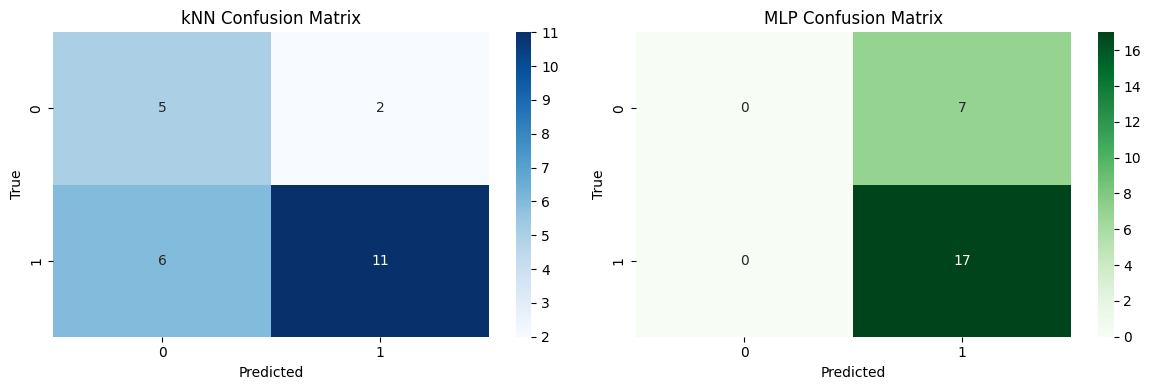

In [ ]:

# Visualize confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# kNN confusion matrix
cmKnn = confusion_matrix(y_test, knnPredictY)
sns.heatmap(cmKnn, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('kNN Confusion Matrix')
axes[0].set_ylabel('True')
axes[0].set_xlabel('Predicted')

# MLP confusion matrix
cmMlp = confusion_matrix(y_test, mlp_predict_y)
sns.heatmap(cmMlp, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('MLP Confusion Matrix')
axes[1].set_ylabel('True')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

##Side-by-Side box plots
*Note: Claude Sonnet 4.5 was used to assist in graphics generation*

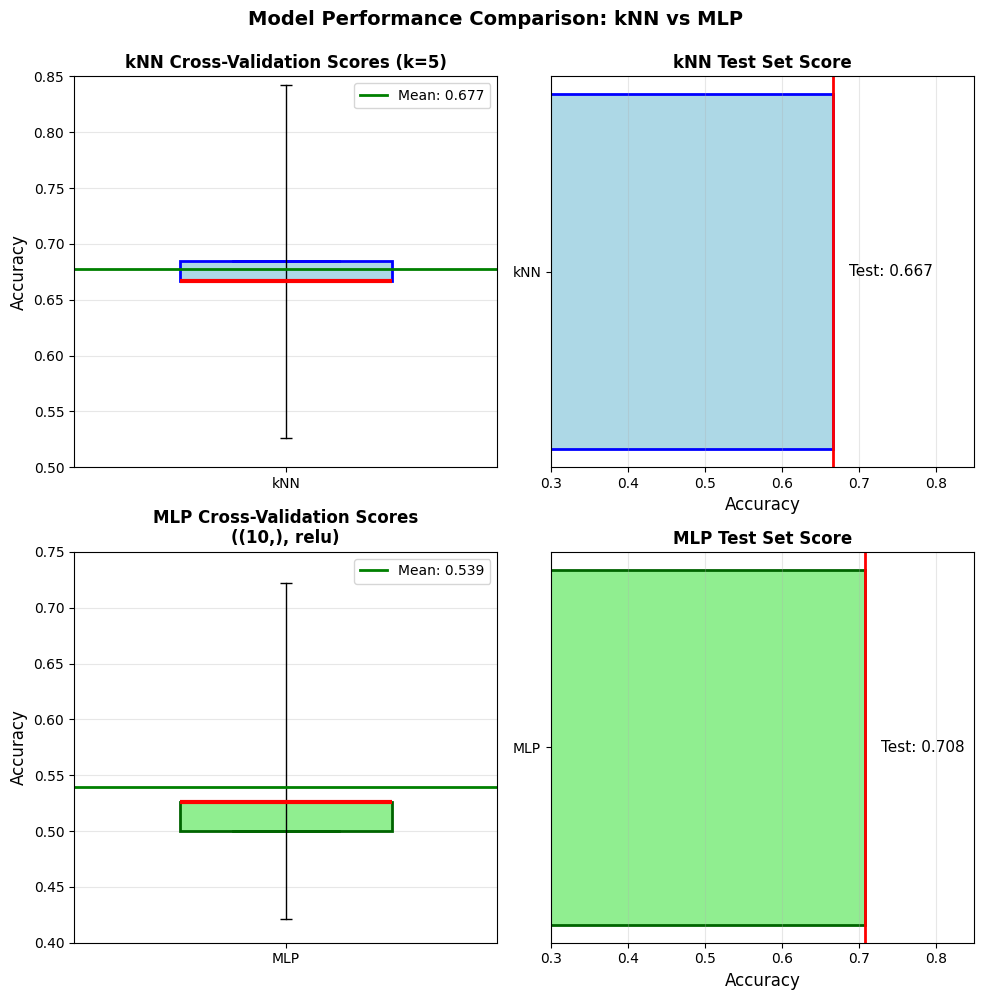

In [ ]:
"""#Combined Model Performance Comparison"""

# Combined: 2x2 matrix with kNN on top, MLP on bottom
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# kNN Cross-Validation Scores
bp1 = axes[0, 0].boxplot(knnCvScores, vert=True, patch_artist=True, widths=0.5,
                    boxprops=dict(facecolor='lightblue', color='blue', linewidth=2),
                    medianprops=dict(color='red', linewidth=3),
                    whiskerprops=dict(color='blue', linewidth=2),
                    capprops=dict(color='blue', linewidth=2),
                    flierprops=dict(marker='_', markerfacecolor='red', markersize=8, linestyle='solid'))
axes[0, 0].set_ylabel('Accuracy', fontsize=12)
axes[0, 0].set_title('kNN Cross-Validation Scores (k={})'.format(knnGrid.best_params_['n_neighbors']),
                      fontsize=12, fontweight='bold')
axes[0, 0].set_xticklabels(['kNN'])
axes[0, 0].set_ylim([0.5, 0.85])
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].axhline(y=knnMeanAcc, color='green', linestyle='solid', linewidth=2, label='Mean: {:.3f}'.format(knnMeanAcc))
axes[0, 0].legend()

# kNN Test Score
axes[0, 1].barh(['kNN'], [knnTestAcc], color='lightblue', edgecolor='blue', linewidth=2, height=0.4)
axes[0, 1].set_xlabel('Accuracy', fontsize=12)
axes[0, 1].set_title('kNN Test Set Score', fontsize=12, fontweight='bold')
axes[0, 1].set_xlim([0.3, .85])
axes[0, 1].grid(True, alpha=0.3, axis='x')
axes[0, 1].axvline(x=knnTestAcc, color='red', linestyle='solid', linewidth=2)
axes[0, 1].text(knnTestAcc + 0.02, 0, 'Test: {:.3f}'.format(knnTestAcc), fontsize=11, va='center')

# MLP Cross-Validation Scores
bp2 = axes[1, 0].boxplot(mlp_cv_scores, vert=True, patch_artist=True, widths=0.5,
                    boxprops=dict(facecolor='lightgreen', color='darkgreen', linewidth=2),
                    medianprops=dict(color='red', linewidth=3),
                    whiskerprops=dict(color='darkgreen', linewidth=2),
                    capprops=dict(color='darkgreen', linewidth=2),
                    flierprops=dict(marker='_', markerfacecolor='red', markersize=8, linestyle='solid'))
axes[1, 0].set_ylabel('Accuracy', fontsize=12)
axes[1, 0].set_title('MLP Cross-Validation Scores\n({}, {})'.format(
    mlpGrid.best_params_['hidden_layer_sizes'],
    mlpGrid.best_params_['activation']),
    fontsize=12, fontweight='bold')
axes[1, 0].set_xticklabels(['MLP'])
axes[1, 0].set_ylim([0.4, 0.75])
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].axhline(y=mlp_mean_acc, color='green', linestyle='solid', linewidth=2, label='Mean: {:.3f}'.format(mlp_mean_acc))
axes[1, 0].legend()

# MLP Test Score
axes[1, 1].barh(['MLP'], [mlp_test_acc], color='lightgreen', edgecolor='darkgreen', linewidth=2, height=0.4)
axes[1, 1].set_xlabel('Accuracy', fontsize=12)
axes[1, 1].set_title('MLP Test Set Score', fontsize=12, fontweight='bold')
axes[1, 1].set_xlim([0.3, 0.85])
axes[1, 1].grid(True, alpha=0.3, axis='x')
axes[1, 1].axvline(x=mlp_test_acc, color='red', linestyle='solid', linewidth=2)
axes[1, 1].text(mlp_test_acc + 0.02, 0, 'Test: {:.3f}'.format(mlp_test_acc), fontsize=11, va='center')

fig.suptitle('Model Performance Comparison: kNN vs MLP', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

#Summary

The comparison between kNN and MLP models reveals that neither performs significantly better statistically. Both models show overlapping confidence intervals in cross-validation (kNN: 0.54-0.82, MLP: 0.40-0.68) and on the test set (kNN: 0.48-0.86, MLP: 0.53-0.89).  
While kNN performed slightly better during cross-validation (68% vs 54%), the MLP achieved higher accuracy on the test set (71% vs 67%). The wide confidence intervals indicate uncertainty due to the relatively small dataset of 117 patients.  
However, in a medical context where adverse events are being predicted, the confusion matrices reveal a critical difference in error types. The kNN model produced 6 false negatives (patients who experienced adverse events but were not flagged), while the MLP model produced 0 false negatives.  
False negatives are particularly concerning in healthcare because they represent patients who will experience adverse events but weren't identified by the model, potentially missing opportunities for preventive intervention.  
Although the MLP has 7 false positives compared to kNN's 2 (meaning it over-predicts adverse events), this is a more acceptable error in medical contexts.  
The MLP essentially acts as a conservative screening tool that flags all patients who might experience adverse events, ensuring
no at-risk patient is missed.  
Therefore, despite the MLP's added complexity and lower cross-validation performance, it is strongly recommended for this clinical application because it eliminates false negatives entirely.